This notebook serves as a control panel for support simulations of network activity propagating along a ridge of CA3 PCs receiving EC input through potentiated EC->PC synapses.

In [2]:
from search import ridge

import PARAMETERS as P

In [ ]:
# Precompute initial voltage/NMDA-conductance distribution for varying EC parameters

# Searcher control panel

In [ ]:
ridge.launch_searchers('sim_0.random', ridge.obj, P, 1)

In [ ]:
ridge.launch_searchers('sim_0.biased', ridge.obj, P, 1)

# Viewer

In [11]:
# list active searchers

In [12]:
# show example trial

In [13]:
# construct embedding

# Tests

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size

### Unit tests of auxiliary functions

##### Parameter conversions

In [2]:
from search.ridge import make_param_conversions

class Cfg(object):
    
    P_RANGES = [
        ('y', [1, 2, 1]),
        ('z', [1, 2, 3]),
        ('w', [5]),
    ]

cfg = Cfg()

p_to_x, x_to_p = make_param_conversions(cfg)

p = {'y': 1.25, 'z': 1.25, 'w': 7}
x_correct = np.array([-0.25, -0.75, 0])

np.testing.assert_array_almost_equal(p_to_x(p), x_correct)

x = np.array([-0.25, -0.75, 0])
p_correct = {'y': 1.25, 'z': 1.25, 'w': 5}

np.testing.assert_equal(x_to_p(x), p_correct)

print('Tests completed successfully.')

Tests completed successfully.


##### Parsing of "forcing" positions

In [3]:
from search.ridge import force_to_x

class Cfg(object):
    
    P_RANGES = [
        ('a', [-5, 15, 3]),
        ('b', [2]),
        ('c', [20, 40, 1]),
    ]
    
    SGM_RAND = .5

np.random.seed(0)

cfg = Cfg()

# check that forced is parsed correctly from dict
force_dict = {'a': 0, 'b': 2, 'c': 35}
x_correct = np.array([-0.75, 0, 0.25])

np.testing.assert_array_almost_equal(force_to_x(cfg, force_dict), x_correct)

force_dict = {'a': 0, 'b': 3, 'c': 35}
x_correct = np.array([-0.75, 0, 0.25])

np.testing.assert_array_almost_equal(force_to_x(cfg, force_dict), x_correct)

# check that random force yields in-bounds x
xs = np.array([force_to_x(cfg, 'random') for _ in range(1000)])

np.testing.assert_equal(np.any(xs[:, 0] > .5), True)
np.testing.assert_equal(np.any(xs[:, 0] < -.5), True)
np.testing.assert_equal(np.all((xs[:, 0] >= -1.5) * (xs[:, 0] <= 1.5)), True)
np.testing.assert_equal(np.all(xs[:, 1] == 0), True)
np.testing.assert_equal(np.any(xs[:, 2] > .1), True)
np.testing.assert_equal(np.any(xs[:, 2] < -.1), True)
np.testing.assert_equal(np.all((xs[:, 2] >= -.5) * (xs[:, 2] <= .5)), True)

print('Tests completed successfully.')

Tests completed successfully.


##### Out-of-bounds correction

In [4]:
from search.ridge import fix_x_if_out_of_bounds

class Cfg(object):
    
    P_RANGES = [
        ('y', [1, 2, 1]),
        ('z', [10, 20, 3]),
        ('w', [5]),
    ]

cfg = Cfg()

xs_raw = np.array([
    [-.25, 1.2, 0],
    [.75, -.12, 0],
    [.1, -1.7, 0],
    [-.6, 1.8, 0],
    [-.25, 1.2, 1],
    [-.6, 1.8, -4],
])

xs_fixed_correct = np.array([
    [-.25, 1.2, 0],
    [.5, -.12, 0],
    [.1, -1.5, 0],
    [-.5, 1.5, 0],
    [-.25, 1.2, 0],
    [-.5, 1.5, 0],
])

xs_fixed = np.array([fix_x_if_out_of_bounds(cfg, x) for x in xs_raw])

np.testing.assert_array_almost_equal(xs_fixed, xs_fixed_correct)

print('Tests completed successfully.')

Tests completed successfully.


##### Random parameter sampling

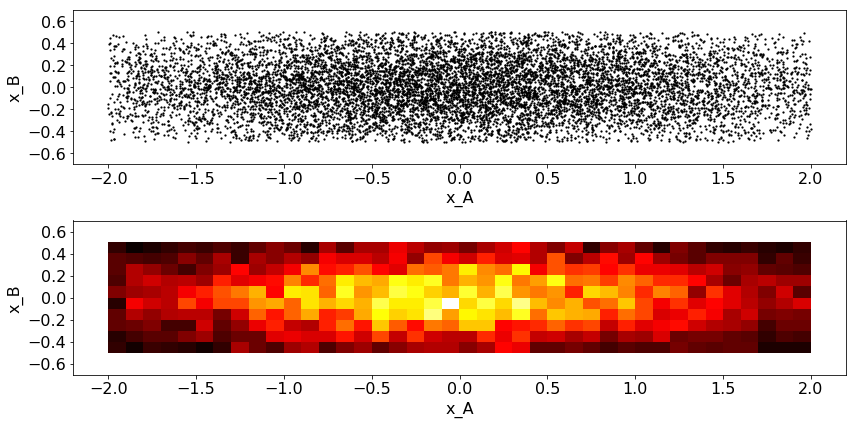

In [5]:
from search.ridge import sample_x_rand

class Cfg(object):
    
    P_RANGES = [
        ('A', [1, 2, 4]),
        ('B', [1, 2, 1]),
    ]
    SGM_RAND = 0.3
    
cfg = Cfg()

xs = np.array([sample_x_rand(cfg) for _ in range(10000)])

fig, axs = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)

axs[0].scatter(xs[:, 0], xs[:, 1], s=5, c='k', lw=0)
axs[1].hist2d(xs[:, 0], xs[:, 1], bins=(40, 10), cmap='hot')

for ax in axs:
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-.7, .7)
    ax.set_xlabel('x_A')
    ax.set_ylabel('x_B')
    set_font_size(ax, 16)

Test passed if scatter and histogram are confined to rectangle (-2, 2, -.5, .5) and have roughly Gaussian shape, with distribution stretched to match rectangle dimensions.

##### Sampling from previous parameter sets

Here we generate 50 result sets where the activity (k) is very close to k_targ, but the speed (s) is far from s_targ, and 50 result sets where s is very close to s_targ, but k is far from k_targ. If our code works correctly, sampling when activity is valued (B_PREV_K >> B_PREV_S) should yield samples from the first 50 (black hist below), and sampling when speed is valued (B_PREV_S >> B_PREV_K) should yield samples from the second 50 (blue hist below).

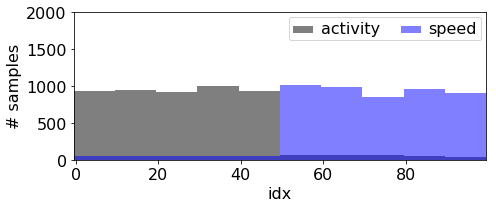

In [6]:
from search.ridge import _sample_x_prev

class Cfg(object):
    
    K_TARG = 10
    S_TARG = 20
    
    ETA_K = .5
    ETA_S = .5
    
    A_PREV = 3
    B_PREV_Y = 0
    B_PREV_K = None
    B_PREV_S = None
    
    @property
    def B_PREV_SUM(self): return self.B_PREV_Y + self.B_PREV_K + self.B_PREV_S
    
# generate result set where half of points are close to K_TARG and half are close to S_TARG
rslts = [
    # samples near K_TARG
    {
        'PROPAGATION': 1,
        'ACTIVITY': 10 + np.random.normal(0, .05),
        'SPEED': 10 + np.random.normal(0, 0.05)
    } for _ in range(50)
] + [
    # samples near S_TARG
    {
        'PROPAGATION': 1,
        'ACTIVITY': 20 + np.random.normal(0, .05),
        'SPEED': 20 + np.random.normal(0, 0.05)
    } for _ in range(50)
]

# corresponding mock parameter set
ps = range(len(rslts))

# build two configs, one weighting k heavily, one weighting s heavily
cfg_k = Cfg()
cfg_k.B_PREV_K = 1
cfg_k.B_PREV_S = 0

cfg_s = Cfg()
cfg_s.B_PREV_K = 0
cfg_s.B_PREV_S = 1

# take samples
idxs_k = [_sample_x_prev(cfg_k, ps, rslts)[1] for _ in range(5000)]
idxs_s = [_sample_x_prev(cfg_s, ps, rslts)[1] for _ in range(5000)]

# plot distributions
fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.hist(idxs_k, bins=np.linspace(-.5, 99.5, 11), color='k', lw=1, alpha=0.5)
ax.hist(idxs_s, bins=np.linspace(-.5, 99.5, 11), color='b', lw=1, alpha=0.5)

ax.legend(['activity', 'speed'], ncol=2)
ax.set_xlim(-.5, 99.5)
ax.set_ylim(0, 2000)
ax.set_xlabel('idx')
ax.set_ylabel('# samples')

set_font_size(ax, 16)

Test passed if gray hist is uniform and left of 50 (activity-weighted samples) and blue hist is uniform and right of 50 (speed-weighted samples), and if there is small dark blue strip on bottom (overlap from random sampling).

##### Generating logical search steps

To test this we generate 4 previous xs, distributed on the corners of the unit square. We then ensure that the derived optimal directions (phi_mean) end up in the correct quadrants when different result sets and config files are used.

In [7]:
from search.ridge import compute_phi_mean

class Cfg():
    
    L_PHI = 5
    
    K_TARG = 10
    S_TARG = 20
    
    ETA_K = .5
    ETA_S = .5
    
    A_PHI = 3
    B_PHI_Y = 0
    B_PHI_K = None
    B_PHI_S = None
    
    @property
    def B_PHI_SUM(self): return self.B_PHI_Y + self.B_PHI_K + self.B_PHI_S

xs = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])

# activity-accurate on top, speed-accurate on bottom
rslts = [
    {'PROPAGATION': 1, 'ACTIVITY': 9.5, 'SPEED': 9.9},
    {'PROPAGATION': 1, 'ACTIVITY': 10.1, 'SPEED': 10.2},
    {'PROPAGATION': 1, 'ACTIVITY': 20.1, 'SPEED': 19.1},
    {'PROPAGATION': 1, 'ACTIVITY': 19.9, 'SPEED': 20.2},
]

# cfg weighting activity-accuracy
cfg_k = Cfg()
cfg_k.B_PHI_K = 10
cfg_k.B_PHI_S = 0

phi_mean = compute_phi_mean(cfg_k, xs, rslts)
sgns = np.sign(phi_mean)
sgns_correct = np.array([-1, 1])

np.testing.assert_almost_equal(Cfg.L_PHI, np.linalg.norm(phi_mean))
np.testing.assert_array_equal(sgns, sgns_correct)

# cfg weighting speed-accuracy
cfg_s = Cfg()
cfg_s.B_PHI_K = 0
cfg_s.B_PHI_S = 10

phi_mean = compute_phi_mean(cfg_s, xs, rslts)
sgns = np.sign(phi_mean)
sgns_correct = np.array([1, -1])

np.testing.assert_almost_equal(Cfg.L_PHI, np.linalg.norm(phi_mean))
np.testing.assert_array_equal(sgns, sgns_correct)

# test that phi_mean is directly down when bottom two xs have equal speeds
rslts = [
    {'PROPAGATION': 1, 'ACTIVITY': 9.5, 'SPEED': 9.9},
    {'PROPAGATION': 1, 'ACTIVITY': 10.1, 'SPEED': 10.2},
    {'PROPAGATION': 1, 'ACTIVITY': 10.2, 'SPEED': 19.1},
    {'PROPAGATION': 1, 'ACTIVITY': 10.1, 'SPEED': 19.1},
]

phi_mean = compute_phi_mean(cfg_s, xs, rslts)
np.testing.assert_almost_equal(phi_mean[0], 0)
np.testing.assert_almost_equal(phi_mean[1], -Cfg.L_PHI)

print('Tests completed successfully.')

Tests completed successfully.


### Unit tests of measurement functions

### Integration test with mock objective function

In [8]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from db import make_session, d_models
from plot import set_font_size
from search import ridge

import PARAMETERS as P

CONFIG_ROOT = 'search.test_config.ridge'

def mock(p, seed):
    """Mock objective function."""
    y = p['RHO_PC']
    k = p['Z_PC']
    s = p['L_PC']
    
    return {'PROPAGATION': y, 'ACTIVITY': k, 'SPEED': s}

##### Random search

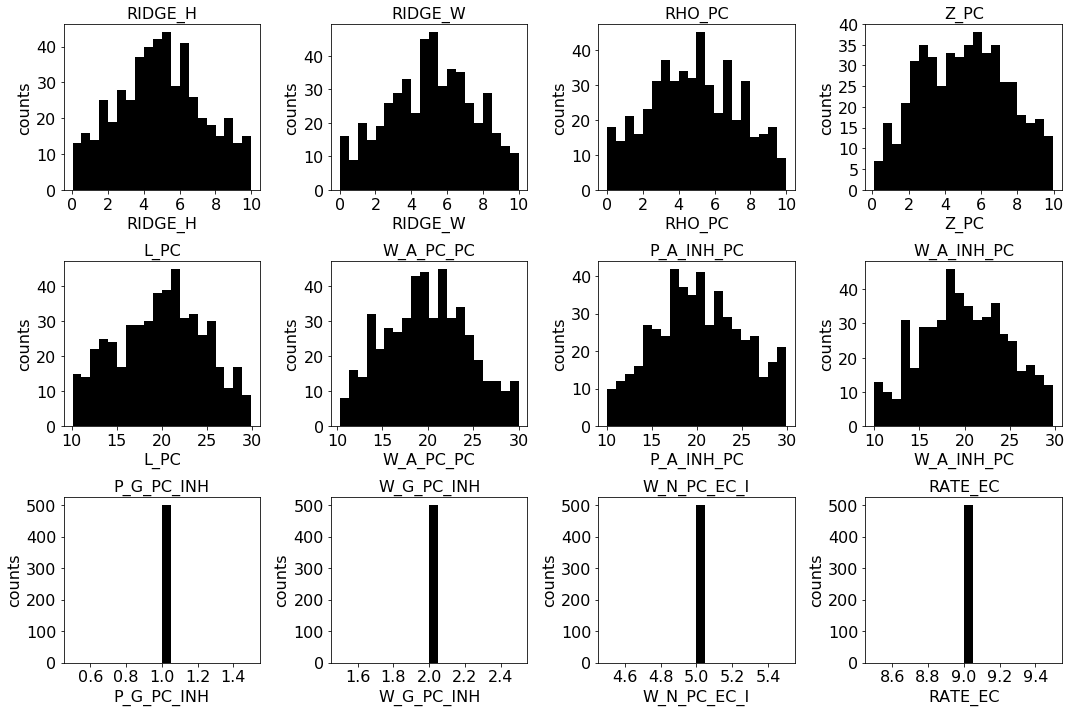

In [9]:
from search.test_config.ridge import random as cfg

N_TRIALS = 500

# perform search
searcher_id = ridge.search(
    'random', mock, P, max_iter=N_TRIALS, seed=0,
    config_root=CONFIG_ROOT, commit='test_random')

# retrieve search results from db
session = make_session()
trials = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id == searcher_id).order_by(
    d_models.RidgeTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), N_TRIALS)

# make sure first trial has centered params
for name, p_range in cfg.P_RANGES:
    if len(p_range) == 3:
        correct = 0.5 * (p_range[0] + p_range[1])
    else:
        correct = p_range[0]
        
    np.testing.assert_equal(getattr(trials[0], name.lower()), correct)

# make param histograms, which should all be normally distributed
names = [name for name, p_range in cfg.P_RANGES]

fig, axs = plt.subplots(3, 4, figsize=(15, 10), tight_layout=True)

for name, ax in zip(names, axs.flatten()):
    
    data = [getattr(trial, name.lower()) for trial in trials]
    ax.hist(data, bins=20, color='k')
    
    ax.axvline
    
    ax.set_xlabel(name)
    ax.set_ylabel('counts')
    ax.set_title(name)
    
    set_font_size(ax, 16)

Test passed if top four rows have approx. normal histograms truncated at 0 and 10, if bottom four rows have approx. normal histograms truncated at 10 and 30, and if bottom rows have delta function histograms.

##### Guided search

Here we use a config file specifying an optimal solution when Z_PC = L_PC = 9, with the other params irrelevant. We ensure its correct functioning by plotting out the sequence of Z_PC and L_PC arrived at by the search process, to ensure they move in the direction of the optimum. We perform the search with two different average step sizes.

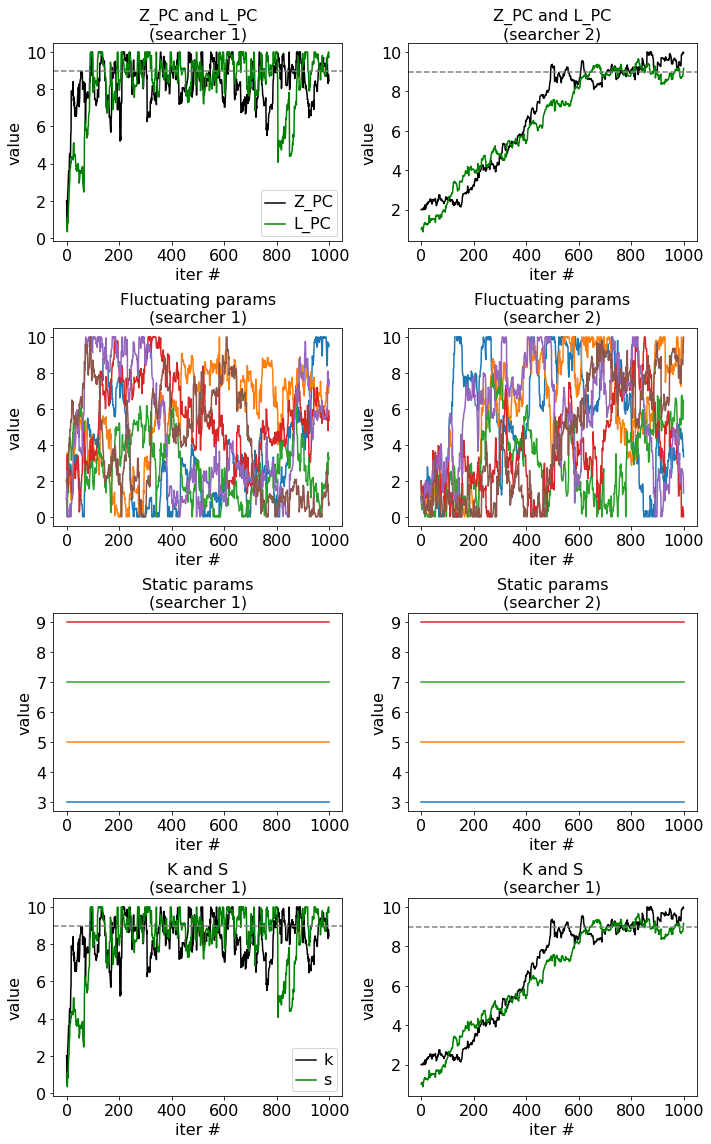

In [10]:
from search.test_config.ridge import guided_1 as cfg_1
from search.test_config.ridge import guided_2 as cfg_2

N_TRIALS = 1000

# perform search for both searchers
searcher_id_1 = ridge.search(
    'guided_1', mock, P, max_iter=N_TRIALS, seed=2,
    config_root=CONFIG_ROOT, commit='test_guided')

searcher_id_2 = ridge.search(
    'guided_2', mock, P, max_iter=N_TRIALS, seed=3,
    config_root=CONFIG_ROOT, commit='test_guided')

# retrieve search results from db
session = make_session()
trials_1 = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id == searcher_id_1).order_by(
    d_models.RidgeTrial.id).all()
trials_2 = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id == searcher_id_2).order_by(
    d_models.RidgeTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials_1), N_TRIALS)
np.testing.assert_equal(len(trials_2), N_TRIALS)

# get z_pc and l_pc
z_pcs_1 = [trial.z_pc for trial in trials_1]
l_pcs_1 = [trial.l_pc for trial in trials_1]
z_pcs_2 = [trial.z_pc for trial in trials_2]
l_pcs_2 = [trial.l_pc for trial in trials_2]

# get propagations, activities, and speeds for each searcher
ys_1 = [trial.propagation for trial in trials_1]
ks_1 = [trial.activity for trial in trials_1]
ss_1 = [trial.speed for trial in trials_1]

ys_2 = [trial.propagation for trial in trials_2]
ks_2 = [trial.activity for trial in trials_2]
ss_2 = [trial.speed for trial in trials_2]

# get fluctuating or static irrelevant params
fluc_1 = []
static_1 = []
for trial in trials_1:
    
    fluc_ = [
        trial.ridge_h, trial.ridge_w, trial.rho_pc,
        trial.w_a_pc_pc, trial.p_a_inh_pc, trial.w_a_inh_pc,
    ]
    
    fluc_1.append(fluc_)
    
    static_ = [
        trial.p_g_pc_inh, trial.w_g_pc_inh,
        trial.w_n_pc_ec_i, trial.rate_ec,
    ]
    
    static_1.append(static_)

fluc_1 = np.array(fluc_1)
static_1 = np.array(static_1)

fluc_2 = []
static_2 = []
for trial in trials_2:
    
    fluc_ = [
        trial.ridge_h, trial.ridge_w, trial.rho_pc,
        trial.w_a_pc_pc, trial.p_a_inh_pc, trial.w_a_inh_pc,
    ]
    
    fluc_2.append(fluc_)
    
    static_ = [
        trial.p_g_pc_inh, trial.w_g_pc_inh,
        trial.w_n_pc_ec_i, trial.rate_ec,
    ]
    
    static_2.append(static_)

fluc_2 = np.array(fluc_2)
static_2 = np.array(static_2)

# plot parameter trajectories
fig, axs = plt.subplots(4, 2, figsize=(10, 16), tight_layout=True)

# plot z_pc and l_pc for searchers 1 and 2
axs[0, 0].plot(z_pcs_1, color='k')
axs[0, 0].plot(l_pcs_1, color='g')
axs[0, 0].legend(['Z_PC', 'L_PC'])
axs[0, 0].axhline(cfg_1.K_TARG, color='gray', ls='--')
axs[0, 0].set_title('Z_PC and L_PC\n(searcher 1)')

axs[0, 1].plot(z_pcs_2, color='k')
axs[0, 1].plot(l_pcs_2, color='g')
axs[0, 1].axhline(cfg_2.K_TARG, color='gray', ls='--')
axs[0, 1].set_title('Z_PC and L_PC\n(searcher 2)')

# plot fluctuating params for both searchers
axs[1, 0].plot(fluc_1)
axs[1, 0].set_title('Fluctuating params\n(searcher 1)')

axs[1, 1].plot(fluc_2)
axs[1, 1].set_title('Fluctuating params\n(searcher 2)')

# plot static params for both searchers
axs[2, 0].plot(static_1)
axs[2, 0].set_title('Static params\n(searcher 1)')

axs[2, 1].plot(static_2)
axs[2, 1].set_title('Static params\n(searcher 2)')

# plot results for each searcher
axs[3, 0].plot(ks_1, color='k')
axs[3, 0].plot(ss_1, color='g')
axs[3, 0].legend(['k', 's'])
axs[3, 0].axhline(cfg_1.K_TARG, color='gray', ls='--')
axs[3, 0].set_title('K and S\n(searcher 1)')

axs[3, 1].plot(ks_2, color='k')
axs[3, 1].plot(ss_2, color='g')
axs[3, 1].axhline(cfg_2.K_TARG, color='gray', ls='--')
axs[3, 1].set_title('K and S\n(searcher 1)')

for ax in axs.flatten():
    
    ax.set_xlabel('iter #')
    ax.set_ylabel('value')
    
    set_font_size(ax, 16)

Test passed if both Z_PC and L_PC (black and green, top panels) approach then hover around their target values (indicated by the gray dashed line), if the second row of panels appears to be basically random, if the third row of panels is flat, and if the bottom row matches the top, except for the labels.

##### Blend of guided and jumping to random points

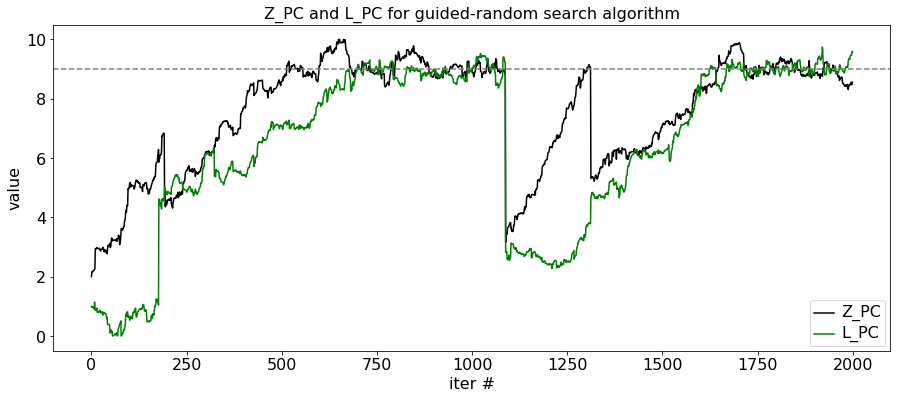

In [11]:
from search.test_config.ridge import blend_rand as cfg

N_TRIALS = 2000

# perform search
searcher_id = ridge.search(
    'blend_rand', mock, P, max_iter=N_TRIALS, seed=0,
    config_root=CONFIG_ROOT, commit='test_blend')

# get trials and params
session = make_session()
trials = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id == searcher_id).order_by(
    d_models.RidgeTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), N_TRIALS)

# get z_pc and l_pc
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.legend(['Z_PC', 'L_PC'])
ax.axhline(cfg.K_TARG, color='gray', ls='--')

ax.set_xlabel('iter #')
ax.set_ylabel('value')
ax.set_title('Z_PC and L_PC for guided-random search algorithm')

set_font_size(ax, 16)

Test passed if Z_PC and L_PC exhibit similar trajectories as in top right of previous figure, except that every once in a while they are randomly translated to a new location.

##### Blend of guided and jumping to previous points

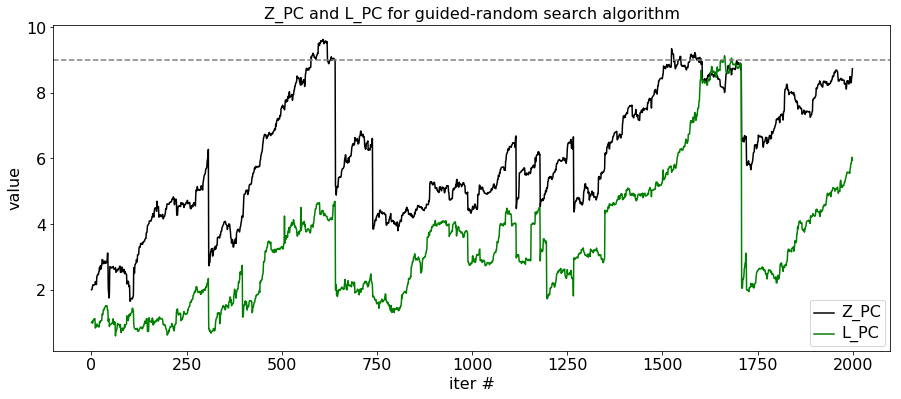

In [12]:
from search.test_config.ridge import blend_prev as cfg

# delete all trials with this smln id
session = make_session()

# first get all searcher ids with this smln id
searchers_old = session.query(d_models.RidgeSearcher.id).filter(
    d_models.RidgeSearcher.smln_id == cfg.SMLN_ID)
searcher_ids_old = [s.id for s in searchers_old]

# delete all trials corresponding to these searchers
trials_old = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id.in_(searcher_ids_old))
trials_old.delete(synchronize_session='fetch')

np.testing.assert_equal(trials_old.count(), 0)
session.commit()
session.close()

N_TRIALS = 2000

# perform search
searcher_id = ridge.search(
    'blend_prev', mock, P, max_iter=N_TRIALS, seed=1,
    config_root=CONFIG_ROOT, commit='test_blend')

# get trials and params
session = make_session()
trials = session.query(d_models.RidgeTrial).filter(
    d_models.RidgeTrial.searcher_id == searcher_id).order_by(
    d_models.RidgeTrial.id).all()

# make sure only N_TRIALS trials exist for this simulation
trials_ = session.query(d_models.RidgeTrial).join(
    d_models.RidgeSearcher).filter(
    d_models.RidgeSearcher.smln_id == cfg.SMLN_ID)
np.testing.assert_equal(trials_.count(), N_TRIALS)

session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), N_TRIALS)

# get z_pc and l_pc
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.legend(['Z_PC', 'L_PC'])
ax.axhline(cfg.K_TARG, color='gray', ls='--')

ax.set_xlabel('iter #')
ax.set_ylabel('value')
ax.set_title('Z_PC and L_PC for guided-random search algorithm')

set_font_size(ax, 16)

Test passed if z_pc (black) and green (l_pc) appear to be moving towards dashed gray line, but occasionally get randomly reset to what appear to previous (z_pc, l_pc) pairs.